<a href="https://colab.research.google.com/github/hitesh-bhatnagar/Using-symptoms-predicting-common-diseases-/blob/main/GDSC_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files.upload()
!mkdir ~.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!/bin/bash
! kaggle datasets download pjmathematician/diseases-and-symptoms

Saving kaggle.json to kaggle.json
cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/pjmathematician/diseases-and-symptoms
License(s): CC-BY-SA-4.0
  0% 0.00/11.9k [00:00<?, ?B/s]
100% 11.9k/11.9k [00:00<00:00, 14.0MB/s]


In [3]:
!unzip diseases-and-symptoms.zip

Archive:  diseases-and-symptoms.zip
  inflating: main.csv                


In [4]:
import shutil
folder_name = 'dataset'
os.makedirs(folder_name,exist_ok=True)
shutil.move('main.csv',folder_name)

'dataset/main.csv'

In [5]:
os.listdir('/content/dataset')

['main.csv']

In [6]:
data = pd.read_csv('/content/dataset/main.csv')

In [7]:
data.head()

,frequency,UMLS:C0457096_yellow sputum,UMLS:C0425560_cardiovascular finding,UMLS:C0020440_hypercapnia,UMLS:C0581912_heavy feeling,UMLS:C0002416_ambidexterity,UMLS:C0521516_polymyalgia,UMLS:C0677500_stinging sensation,UMLS:C0392680_shortness of breath,UMLS:C0030252_palpitation,...,UMLS:C0030193_pain,UMLS:C0239832_numbness of hand,UMLS:C0277977_Murphy's sign,UMLS:C0740844_air fluid level,UMLS:C0026827_muscle hypotonia,UMLS:C0010200_cough,UMLS:C0043094_weight gain,UMLS:C0600142_hot flush,UMLS:C0312422_blackout,label
0,3363.0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,UMLS:C0020538_hypertensive disease
1,1421.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,UMLS:C0011847_diabetes
2,1337.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,UMLS:C0011570_depression mental^UMLS:C0011581_...
3,1284.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,UMLS:C0010054_coronary arteriosclerosis^UMLS:C...
4,1029.0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,UMLS:C0032285_pneumonia


In [8]:
# Define groups for diseases
disease_groups = {
    'Respiratory': [
        'UMLS:C0457096_yellow sputum', 'UMLS:C0392680_shortness of breath', 'UMLS:C0010200_cough',
        'UMLS:C0239133_hacking cough', 'UMLS:C0043144_wheezing', 'UMLS:C0015967_fever',
        'UMLS:C0239134_productive cough', 'UMLS:C0037384_snore', 'UMLS:C0019079_haemoptysis',
        'UMLS:C0028081_night sweat', 'UMLS:C0425491_catching breath', 'UMLS:C0425449_gasping for breath',
        'UMLS:C0016204_flatulence', 'UMLS:C0231528_myalgia'
    ],
    'Cardiovascular': [
        'UMLS:C0425560_cardiovascular finding', 'UMLS:C0030252_palpitation', 'UMLS:C0020538_hypertensive disease',
        'UMLS:C0238705_left atrial hypertrophy', 'UMLS:C1320716_cardiovascular event',
        'UMLS:C0232258_pansystolic murmur', 'UMLS:C0010054_coronary arteriosclerosis',
        'UMLS:C0018800_cardiomegaly', 'UMLS:C0235710_chest discomfort', 'UMLS:C0012833_dizziness',
        'UMLS:C0008031_pain chest', 'UMLS:C0002962_angina pectoris'
    ],
    'Endocrine': [
        'UMLS:C0011847_diabetes', 'UMLS:C0020621_hypokalemia', 'UMLS:C0020625_hyponatremia',
        'UMLS:C0020440_hypercapnia', 'UMLS:C0034642_rale'
    ],
    'Psychological': [
        'UMLS:C0150041_feeling hopeless', 'UMLS:C0233467_inappropriate affect', 'UMLS:C0877040_fear of falling',
        'UMLS:C0085632_indifferent mood', 'UMLS:C0085631_agitation', 'UMLS:C0424068_verbal auditory hallucinations',
        'UMLS:C0438696_suicidal', 'UMLS:C0424109_weepiness', 'UMLS:C0344315_mood depressed',
        'UMLS:C0233762_hallucinations auditory', 'UMLS:C0233763_hallucinations visual', 'UMLS:C0030318_panic'
    ],
    'Neurological': [
        'UMLS:C0233605_titubation', 'UMLS:C0424230_motor retardation', 'UMLS:C0271202_hemianopsia homonymous',
        'UMLS:C0239134_ataxia', 'UMLS:C0027497_nausea', 'UMLS:C0013132_drool', 'UMLS:C0009024_clonus',
        'UMLS:C0006318_bruit', 'UMLS:C0234450_sleepy', 'UMLS:C0576456_poor feeding'
    ],
    'Other': [
        # Diseases or symptoms not categorized elsewhere
        'UMLS:C0000737_pain abdominal', 'UMLS:C0242143_uncoordination', 'UMLS:C0015967_fever',
        'UMLS:C0038990_sweat', 'UMLS:C0234238_ache', 'UMLS:C0234999_elation', 'UMLS:C0242143_uncoordination'
    ]
}


In [9]:
def map_to_category(disease_label):
    for category, diseases in disease_groups.items():
        for disease in diseases:
            if disease in disease_label:
                return category
    return 'Other'

data['category'] = data['label'].apply(map_to_category)

print(data['category'].value_counts())

data.to_csv('grouped_dataset.csv',index = False)

category
Other             131
Cardiovascular      2
Endocrine           1
Name: count, dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

data = pd.read_csv('grouped_dataset.csv')

# Step 2: Separate features and target
X = data.drop(['category', 'label'], axis=1).values  # Drop the category and original label columns
y = data['category'].values  # Target variable (grouped category)

# Step 3: Encode the target variable (categories) into numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the label encoder for future use
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Step 4: Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Save the scaler for future use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Step 5: Train-test split (30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Step 6: Build the neural network model (simplified model to prevent overfitting)
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Input layer
    Dropout(0.3),
    Dense(32, activation='relu'),  # Hidden layer with reduced complexity
    Dropout(0.3),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Output layer (one neuron per class)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 7: Implement Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 8: Train the model with early stopping
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.1,  # Use 10% of training data for validation
                    callbacks=[early_stopping])

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Loss: {loss:.2f}")






Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5917 - loss: 0.9376 - val_accuracy: 0.8000 - val_loss: 0.7992
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8822 - loss: 0.6827 - val_accuracy: 1.0000 - val_loss: 0.6185
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9322 - loss: 0.5785 - val_accuracy: 1.0000 - val_loss: 0.4601
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9583 - loss: 0.3758 - val_accuracy: 1.0000 - val_loss: 0.3299
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9657 - loss: 0.3343 - val_accuracy: 1.0000 - val_loss: 0.2302
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9776 - loss: 0.2259 - val_accuracy: 1.0000 - val_loss: 0.1600
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9776 - loss: 0.1543 - val_accuracy: 1.0000 - val_loss: 0.1130
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9709 - loss: 0.1380 - val_accuracy: 1.0000 - val_loss: 0.0829
Epoch 9/50
6/

In [13]:
# Step 10: Save the trained model as TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model and label encoder saved successfully!")

Saved artifact at '/tmp/tmp48flnuvf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 408), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132087368937568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132087369237600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132087369241120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132087369239008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132087369240592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132087369243936: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model and label encoder saved successfully!


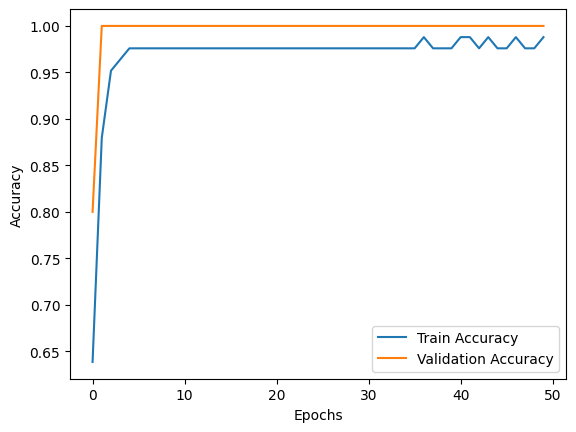

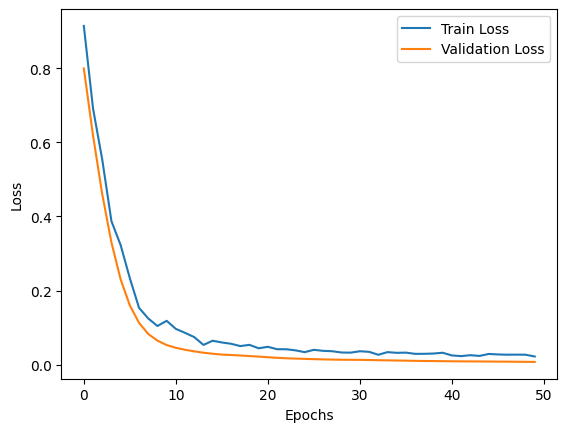

In [14]:
# Step 11: Optionally, plot training & validation accuracy and loss to analyze overfitting
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()